In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
data = pd.read_csv('data/data.csv')

In [4]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Purely intuitively, most frauds are committed because of large amounts of money being deducted at the source and added at the destination account. So we create two additional fields, `diffOrig` and `diffDest` which is the difference in amount of money occured in each transaction.

In [5]:
data['diffOrig'] = data['oldbalanceOrg'] - data['newbalanceOrig']
data['diffDest'] = data['oldbalanceDest'] - data['newbalanceDest']

There are three categorical variables - `type`,`nameOrig`,`nameDest`. The `nameOrig` and `nameDest` have too many categories with none of them holding a significant majority. So we shall drop them. We will keep `type` because of the limited number of categories.

In [6]:
x = data['nameDest'].value_counts(normalize=True)*100

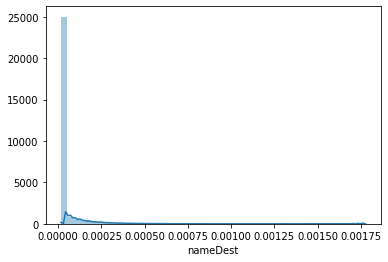

In [7]:
sns.distplot(x)

Will probably end up discarded sourceDest and nameDest because the frequencies of individual names are too low as seen in the distribution plot. The plot normalized the frequency of each `nameDest` and plotted the number of occurences for a specific range of frequencies. It shows that a large number of destination accounts appear only a few times.<br>
We move on to the payment types.

In [8]:
data['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

For each transaction type, we obtain how many were flagged as frauds, and how many weren't.

In [9]:
pd.crosstab(data['type'],data['isFraud'])

isFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,528812,4097


Checking for the number of NA values.

In [10]:
print('NA values\n',data.isna().sum())
print('Null values\n',data.isnull().sum())

NA values
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
diffOrig          0
diffDest          0
dtype: int64
Null values
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
diffOrig          0
diffDest          0
dtype: int64


This tells us that no `NULL` data or `NaN` data is present in the data, so we don't need to deal with them here.

Except `type`, each categorical variable is only a tiny percentage. We attempt to build a model without the other two categorical variables and one-hot encode the `type` variable. The `nameOrig` and `nameDest` columns are dropped.

In [11]:
data_no_names = data.drop(['nameOrig','nameDest'], axis=1)

Since there's a limited number of levels and limited variation in the `step` variable, it is normalized.

In [12]:
data['step'].value_counts()

19     51352
18     49579
187    49083
235    47491
307    46968
       ...  
725        4
245        4
655        4
112        2
662        2
Name: step, Length: 743, dtype: int64

So we need to use three preprocessors:
<li> Normalizer - to convert the step variable to a 0-1 scale because of limited range and levels.
<li> StandardScaler - to convert the amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest, diffOrig, and diffDest to their z-scores $\frac{x-\mu}{\sigma}$.
<li> One-Hot Encoding - done using pandas.get_dummies to convert type to dummy variables. 

In [13]:
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder

In [14]:
sc = StandardScaler()
norm = Normalizer()
one_hot = OneHotEncoder()

One-hot encoding all categorical data. We already removed the categorical data that didn't seem useful.

In [15]:
data_no_names = pd.get_dummies(data_no_names)

Normalizing steps column and making the changes to the column.

In [16]:
data_no_names['step'] = norm.fit_transform(data_no_names['step'].values.reshape(1,-1)).reshape(-1,1)

Creating test and validate data by extracting `isFraud` and `isFlaggedFraud` columns, and dropping them from main dataset.

In [17]:
frauds = data_no_names['isFraud']
validate = data_no_names['isFlaggedFraud']
data_no_names = data_no_names.drop(['isFraud','isFlaggedFraud'], axis = 1)

Using standard scaler on all other numerical data that isn't normalized or categorical.

In [18]:
for col in ['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','diffOrig','diffDest']:
    data_no_names[col] = sc.fit_transform(np.array(data_no_names[col]).reshape(-1,1))

We will now verify if our preprocessing was done properly.

In [19]:
data_no_names.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,diffOrig,diffDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0.000001,-0.281560,-0.229810,-0.237622,-0.323814,-0.333411,0.211876,0.152896,0,0,0,1,0
1,0.000001,-0.294767,-0.281359,-0.285812,-0.323814,-0.333411,0.157490,0.152896,0,0,0,1,0
2,0.000001,-0.297555,-0.288654,-0.292442,-0.323814,-0.333411,0.146011,0.152896,0,0,0,0,1
3,0.000001,-0.297555,-0.288654,-0.292442,-0.317582,-0.333411,0.146011,0.178952,0,1,0,0,0
4,0.000001,-0.278532,-0.274329,-0.282221,-0.323814,-0.333411,0.224345,0.152896,0,0,0,1,0


The steps are normalized, all other values are standardized, and the type has been converted to dummy variables.

Let us now count the number of 1s and 0s in the `isFraud` field.

In [20]:
print(frauds.value_counts()/frauds.value_counts().sum())

0    0.998709
1    0.001291
Name: isFraud, dtype: float64


Here, we can see that the 1's or frauds are only 0.1% of the total transactions. This is extremely unbalanced, and performing random splitting and sampling results runs the risk this bias not being represented in the training and testing sets. So we use stratified sampling to get past this challenge.

### What and Why is Stratified Sampling?
Small no. of 1s, and random_split may not represent properly. [Resource](https://medium.com/@411.codebrain/train-test-split-vs-stratifiedshufflesplit-374c3dbdcc36)

Stratified Sampling is a **sampling technique** that is best used when a statistical population can easily be broken down into distinctive sub-groups. Then samples are taken from each sub-groups based on the ratio of the sub groups size to the total population. We can see that the 1's are a tiny fraction of the output class.  Using Stratified Sampling technique ensures that there will be selection from each sub-group (0 or 1) and prevents the chance of omitting one sub-group leading to sampling bias thus making the dog population happy!

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit
strat_shuffle_split = StratifiedShuffleSplit(n_splits = 1,test_size=0.3, random_state=6)
for train_index, test_index in strat_shuffle_split.split(data_no_names,frauds):
    X_train,X_test = data_no_names.iloc[train_index], data_no_names.iloc[test_index]
    Y_train,Y_test = frauds.iloc[train_index], frauds.iloc[test_index]

Importing the RandomForestClassifier

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

In K-Fold cross validation, the dataset is split into _k_ parts. One part is held back and the other parts are used for testing. Stratified K-Fold is a variation of KFold that uses stratified folds. The folds are made by preserving the percentage of samples for each class.

In [23]:
skf = StratifiedKFold(n_splits = 6, shuffle=True, random_state=42)
rf = RandomForestClassifier(n_estimators = 15, random_state=42)
i=0
scores = []
from sklearn.model_selection import cross_val_score
for train_index, test_index in skf.split(X_train, Y_train):
    X_train_skf, X_test_skf = X_train.iloc[train_index], X_train.iloc[test_index]
    Y_train_skf, Y_test_skf = Y_train.iloc[train_index], Y_train.iloc[test_index]
    model = rf.fit(X_train_skf, Y_train_skf)
    scores.append(model.score(X_test_skf,Y_test_skf))
print('Forest trained')

Forest trained


In [24]:
print(rf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=15,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


Now that our model is trained, let us examine which features turned out to be the most important.<br>

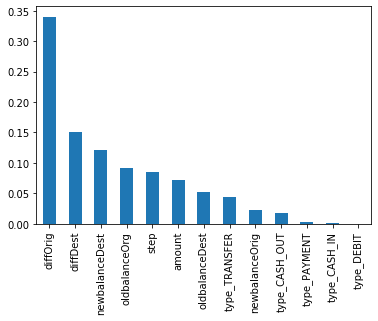

In [25]:
feature_imp = pd.Series(model.feature_importances_,index=X_test.columns).sort_values(ascending=False)
ax = feature_imp.plot(kind='bar')

<p>It is observed that `diffOrig`, the feature that we created from the difference in balance at the origin, and `diffDest`, the feature that we created from the difference in balance at the destination are the most important features.</p>
<p>We had also observed previously using crosstables that all the frauds happened when the transaction type was TRANSFER or CASH_OUT. While this seems to be holding true for transfers, it does not work too well for cash outs. This has to be improved using model tuning.

In [26]:
res = model.predict(X_test)

<p>As we saw, this was an imbalanced classification problem due to the small fraction of 1's in the data. So accuracy on it's own is not a good measure of whether our model did well. We need to focus on two metrics, precision and recall.</p>
<p>Precision measures how accurately the model measures predicted positives.
$$precision=\frac{true\ positive}{true\ positive\ +\ false\ positive}$$
</p>
<p>Recall actually calculates how many of the Actual Positives our model capture through labeling it as Positive.
$$precision=\frac{true\ positive}{true\ positive\ +\ false\ negative}$$
</p>
<p>
    These metrics are combined to calculate the f1-score. 
</p>

More resources:<br>
https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9<br>
https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c

In [27]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,f1_score
print('********** CLASSIFICATION REPORT **********')
print(classification_report(res, Y_test))
print('\n********** CONFUSION MATRIX **********')
print(confusion_matrix(res, Y_test))
print('\n********** F1 SCORE **********')
print(f1_score(res, Y_test))

********** CLASSIFICATION REPORT **********
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906743
           1       0.80      0.97      0.88      2043

    accuracy                           1.00   1908786
   macro avg       0.90      0.98      0.94   1908786
weighted avg       1.00      1.00      1.00   1908786


********** CONFUSION MATRIX **********
[[1906260     483]
 [     62    1981]]

********** F1 SCORE **********
0.8790769913467937


### Tuning the model
Personally, 87% is a good start. But we can always try to improve the accuracy. So we turn to Grid Search. Grid Search fits the model for different combinations of hyperparameters and returns the combination with the best scores.

In [28]:
from sklearn.model_selection import GridSearchCV
n_estimators = [10, 20]
max_depth = [5, 8]
min_samples_split = [1, 2, 5]
min_samples_leaf = [1, 2] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

We will now fit the model for both kinds of scores; precision and recall.

In [29]:
scores = ['precision', 'recall']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    
    clf = GridSearchCV(
        RandomForestClassifier(), hyperF, scoring='%s_macro' % score,
        cv = 3, verbose = 1, n_jobs = -1
    )
    clf.fit(X_train, Y_train)
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = Y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))
    print(f1_score(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 16.2min finished


Best parameters set found on development set:

{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}

Grid scores on development set:

nan (+/-nan) for {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 10}
nan (+/-nan) for {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 20}
0.999 (+/-0.001) for {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
0.999 (+/-0.001) for {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
0.999 (+/-0.001) for {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
0.999 (+/-0.001) for {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 20}
nan (+/-nan) for {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 10}
nan (+/-nan) for {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 20}
0.999 (+/-0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 16.3min finished


Best parameters set found on development set:

{'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 20}

Grid scores on development set:

nan (+/-nan) for {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 10}
nan (+/-nan) for {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 20}
0.748 (+/-0.118) for {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
0.708 (+/-0.013) for {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
0.720 (+/-0.059) for {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
0.742 (+/-0.082) for {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 20}
nan (+/-nan) for {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 10}
nan (+/-nan) for {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 20}
0.696 (+/-0

The max f1-score obtained is less than our original method without any tuning! This didn't work as well as we thought it would. Maybe we should try a different model. Let us try out a support vector machine classifier now.

In [30]:
from sklearn.svm import LinearSVC
skf = StratifiedKFold(n_splits = 3, shuffle=True, random_state=6)
svc = LinearSVC(dual=False, random_state=42)
i=0
scores = []
from sklearn.model_selection import cross_val_score
for train_index, test_index in skf.split(X_train, Y_train):
    X_train_skf, X_test_skf = X_train.iloc[train_index], X_train.iloc[test_index]
    Y_train_skf, Y_test_skf = Y_train.iloc[train_index], Y_train.iloc[test_index]
    svc_model = svc.fit(X_train_skf, Y_train_skf)
    scores.append(svc_model.score(X_test_skf,Y_test_skf))
    i += 1
print('SVC trained')

SVC trained


In [31]:
res = svc_model.predict(X_test)

We will find the metrics for the Support Vector Classifier.

In [32]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,f1_score
print('********** CLASSIFICATION REPORT **********')
print(classification_report(res, Y_test))
print('\n********** CONFUSION MATRIX **********')
print(confusion_matrix(res, Y_test))
print('\n********** F1 SCORE **********')
print(f1_score(res, Y_test))

********** CLASSIFICATION REPORT **********
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1907898
           1       0.35      0.97      0.52       888

    accuracy                           1.00   1908786
   macro avg       0.68      0.99      0.76   1908786
weighted avg       1.00      1.00      1.00   1908786


********** CONFUSION MATRIX **********
[[1906298    1600]
 [     24     864]]

********** F1 SCORE **********
0.5155131264916468


### Exporting the Models
The models can be found in the `models` directory.

In [36]:
import joblib
filename = 'random_forest.sav'
joblib.dump(model, filename)

filename = 'random_forest_grid_search.sav'
joblib.dump(clf, filename)

filename = 'svc.sav'
joblib.dump(svc, filename)

['svc.sav']

### Conclusions
<p>Out of the box, the random forest classifier works the best. The different combinations of trees detects fraudulent transactions the best based on the f1 score. Hyperparameter tuning made it worse, though it should be noted that a grid search to find an ideal set of parameters required way more computing power than my laptop can manage.</p> 
<p>The SVC does not compare at all in performance in this case, though it is also the quickest model to train.</p>
<p> Increasing the number of folds and estimators only results in marginal increase in the f1-score but increases the computation time significantly.</p>
<p>The most useful features in classification turn out to be the features that were created from existing features, `diffOrig` and `diffDest`.